In [4]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 

from skimage.io import imshow

from skimage.io import imshow, imread
from skimage.color import rgb2gray

import dill as pickle

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.utils import to_categorical

np.random.seed(33)

### To replicate the process, run the notebook from here. 
This notebook relies on the first two steps outlined in the README (Hint: 1. Download Data, 2. Run load.py)
You can skip ahead if you want to load results from my trained model instead of training the model yourself. 

In [6]:
df_test = pd.read_csv('../data/test_labels.csv')
df_train = pd.read_csv('../data/train_labels.csv')

bw_loaded = np.load('../data/bw_images.npz')
X_train= bw_loaded['a']
X_test = bw_loaded['b']

X_test = X_test.reshape(-1,80,60,1)
X_train = X_train.reshape(-1,80,60,1)

In [46]:
def pick_ylabels(column):
    y_train = df_train[column].copy().astype('category').cat.codes
    y_test = df_test[column].copy().astype('category').cat.codes
    return (y_train.values, y_test.values)

y_train0, y_test0 = pick_ylabels('masterCategory')

In [9]:
y_train = to_categorical(y_train0)
y_test = to_categorical(y_test0)

In [10]:
y_train.shape

(25439, 4)

In [12]:
cnn1 = models.Sequential()

In [13]:
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(80,60,1)))
#MaxPool reduces dimensionality of each feature
cnn1.add(layers.MaxPooling2D((2, 2)))
#Dropout to reduce overfitting
cnn1.add(Dropout(0.25))

cnn1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.25))

cnn1.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn1.add(Dropout(0.4))

In [14]:
cnn1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 58, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 29, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 39, 29, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 11, 128)       7

In [15]:
cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dropout(0.3))
cnn1.add(Dense(4, activation='softmax'))

In [16]:
cnn1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
cnn1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=1)

In [27]:
# Saving is optional; convenient for viewing results without refitting model
cnn1.save('cnn-main.h5')

### To replicate results without fitting model, start here : 

In [24]:
### Skip this cell if you started from beginning of notebook
cnn1 = load_model('../Results/json/cnn-main.h5')

In [25]:
y_true = y_test0

In [26]:
# get the predictions for the test data
predicted_classes = cnn1.predict_classes(X_test)

# get the indices to be plotted
correct = np.nonzero(predicted_classes==y_test0)[0]
incorrect = np.nonzero(predicted_classes!=y_test0)[0]

In [30]:
cat_list = ['Accessories', 'Apparel', 'Footwear', 'Personal Care']
from sklearn.metrics import classification_report
target_names = ["Class {}: {}".format(i, ix) for i, ix in enumerate(cat_list)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

                        precision    recall  f1-score   support

  Class 0: Accessories       0.93      0.98      0.95      1626
      Class 1: Apparel       0.99      0.97      0.98      2603
     Class 2: Footwear       1.00      0.99      0.99      1826
Class 3: Personal Care       0.94      0.93      0.93       385

              accuracy                           0.97      6440
             macro avg       0.96      0.97      0.97      6440
          weighted avg       0.97      0.97      0.97      6440



In [31]:
wrong_arr = np.array([predicted_classes[incorrect], y_test0[incorrect]]).transpose()
wrong_df = pd.DataFrame(wrong_arr, columns=['Predicted','True'])

In [35]:
color_loaded = np.load('../data/color_images.npz')
color_test= color_loaded['b']

In [36]:
cat_dict = {k:v for k, v in enumerate(cat_list)}

In [37]:
wrong_cat = wrong_df.Predicted.apply(lambda x: cat_dict[x])

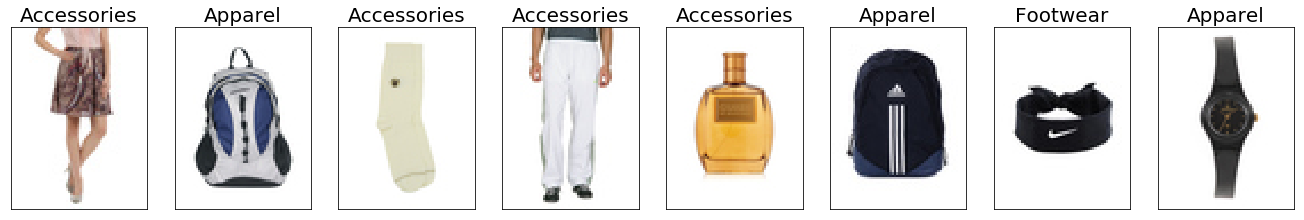

In [38]:
fig, axs = plt.subplots(1, 8, figsize=(23,4))
for i, ax in enumerate(axs.flatten()):
    ax.imshow( color_test[incorrect[i]].reshape(80,60,3)/255 )
    #print(topwear_idx[i])
    ax.set_xticks([])
    ax.set_yticks([]);
    #ax.set_ylabel('{}')
    ax.set_title('{}'.format(wrong_cat[i]), fontsize=20)
plt.subplots_adjust(hspace = 0.7)